In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
from scipy.stats.mstats import winsorize

df1 = pd.read_csv('hw2_data.csv')
df2 = pd.read_csv('monthly.csv')

In [2]:
mask_small_cap = df1['lipper_class'] == 'SCVE'
df1_small = df1[mask_small_cap]
df1_small['Year'] = pd.DatetimeIndex(df1_small['caldt']).year
df1_small

,summary_period2,crsp_fundno,caldt,tna_latest,cusip8,crsp_portno,fund_name,lipper_class,lipper_class_name,Year
2010,AQ,292,12/31/1999,15.1,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,SCVE,Small-Cap Value Funds,1999
3230,AQ,479,12/31/1999,33.5,NaN,NaN,The DLB Fund Group: DLB Enterprise III Fund,SCVE,Small-Cap Value Funds,1999
3231,AQ,479,12/29/2000,17.2,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,SCVE,Small-Cap Value Funds,2000
4210,AQ,657,12/31/1999,43.2,NaN,NaN,1838 Investment Advisors Funds: 1838 Small Cap...,SCVE,Small-Cap Value Funds,1999
4259,AQ,671,12/31/1999,85.3,NaN,NaN,Evergreen Select Equity Trust: Evergreen Selec...,SCVE,Small-Cap Value Funds,1999
...,...,...,...,...,...,...,...,...,...,...
635502,AQ,95944,12/31/2019,0.9,98148K12,1051382.0,World Funds Trust: Clifford Capital Focused Sm...,SCVE,Small-Cap Value Funds,2019
635533,AQ,95975,12/31/2019,0.1,46143U30,1051431.0,Investment Managers Series Trust: WCM Focused ...,SCVE,Small-Cap Value Funds,2019
635534,AQ,95976,12/31/2019,0.3,46143U40,1051431.0,Investment Managers Series Trust: WCM Focused ...,SCVE,Small-Cap Value Funds,2019
635722,AQ,96331,12/31/2019,168.9,NaN,NaN,Pacific Select Fund: Small-Cap Equity Portfoli...,SCVE,Small-Cap Value Funds,2019


In [3]:
# List the fundno of all the small cap funds
small_cap_id = df1_small['crsp_fundno'].unique().tolist()

In [4]:
# Get Small Cap Funds returns
df2_small = df2[df2['crsp_fundno'].isin(small_cap_id)]
df2_small

,caldt,crsp_fundno,mtna,mret,mnav
23084,02/27/1998,292,0.100,NaN,NaN
23085,03/31/1998,292,44.330,R,10.3800000
23086,04/30/1998,292,55.462,-0.003854,10.3400000
23087,05/29/1998,292,55.575,-0.059961,9.7200000
23088,06/30/1998,292,53.860,-0.045267,9.2800000
...,...,...,...,...,...
8121382,02/28/2020,96402,8.2,-0.108787,8.52
8121383,03/31/2020,96402,10.6,-0.281690,6.12
8121384,04/30/2020,96402,34,0.225490,7.5
8121385,05/29/2020,96402,44.3,0.049333,7.87


In [5]:
# Need to clean the return column 
df2_small['mret'].value_counts()

R            1540
0.000000      921
0.040000       43
0.047619       41
0.034483       39
             ... 
-0.126134       1
0.056810        1
-0.030319       1
0.085150        1
0.071492        1
Name: mret, Length: 107329, dtype: int64

In [6]:
# Replace 'R' values as null then drop null 
mask_R = df2_small['mret'] == 'R'
df2_small.loc[mask_R,'mret'] = np.nan
df2_small.dropna(subset=['mret'], inplace=True)

In [7]:
df2_small['mret'].value_counts()

0.000000     921
0.040000      43
0.047619      41
0.034483      39
0.027778      39
            ... 
-0.061682      1
-0.101236      1
-0.045423      1
0.055397       1
-0.055790      1
Name: mret, Length: 107328, dtype: int64

In [8]:
# Extract year from the caldt column
df2_small['Year'] = pd.DatetimeIndex(df2_small['caldt']).year
df2_small['mret'] = df2_small['mret'].astype(float)
df2_small

,caldt,crsp_fundno,mtna,mret,mnav,Year
23086,04/30/1998,292,55.462,-0.003854,10.3400000,1998
23087,05/29/1998,292,55.575,-0.059961,9.7200000,1998
23088,06/30/1998,292,53.860,-0.045267,9.2800000,1998
23089,07/31/1998,292,42.274,-0.113147,8.2300000,1998
23090,08/31/1998,292,32.765,-0.182260,6.7300000,1998
...,...,...,...,...,...,...
8121382,02/28/2020,96402,8.2,-0.108787,8.52,2020
8121383,03/31/2020,96402,10.6,-0.281690,6.12,2020
8121384,04/30/2020,96402,34,0.225490,7.5,2020
8121385,05/29/2020,96402,44.3,0.049333,7.87,2020


In [9]:
# Get 12M returns for individual small cap funds
df2_small_groupby = df2_small.groupby(['crsp_fundno', 'Year'])[['mret']].sum().reset_index()
df2_small_groupby

,crsp_fundno,Year,mret
0,292,1998,-0.309234
1,292,1999,0.000903
2,292,2000,0.042715
3,479,1995,0.088658
4,479,1996,0.143574
...,...,...,...
17033,96331,2017,0.089430
17034,96331,2018,-0.121422
17035,96331,2019,0.233496
17036,96331,2020,-0.180112


In [10]:
# Merge fund summary with return 
df_merged = pd.merge(df1_small, df2_small_groupby, how='left', left_on=['crsp_fundno', 'Year'], right_on=['crsp_fundno', 'Year'])
df_merged['tna_latest'] = df_merged['tna_latest'].astype(float)
df_merged

,summary_period2,crsp_fundno,caldt,tna_latest,cusip8,crsp_portno,fund_name,lipper_class,lipper_class_name,Year,mret
0,AQ,292,12/31/1999,15.1,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,SCVE,Small-Cap Value Funds,1999,0.000903
1,AQ,479,12/31/1999,33.5,NaN,NaN,The DLB Fund Group: DLB Enterprise III Fund,SCVE,Small-Cap Value Funds,1999,-0.071681
2,AQ,479,12/29/2000,17.2,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,SCVE,Small-Cap Value Funds,2000,0.018727
3,AQ,657,12/31/1999,43.2,NaN,NaN,1838 Investment Advisors Funds: 1838 Small Cap...,SCVE,Small-Cap Value Funds,1999,-0.088751
4,AQ,671,12/31/1999,85.3,NaN,NaN,Evergreen Select Equity Trust: Evergreen Selec...,SCVE,Small-Cap Value Funds,1999,-0.025153
...,...,...,...,...,...,...,...,...,...,...,...
6843,AQ,95944,12/31/2019,0.9,98148K12,1051382.0,World Funds Trust: Clifford Capital Focused Sm...,SCVE,Small-Cap Value Funds,2019,0.051526
6844,AQ,95975,12/31/2019,0.1,46143U30,1051431.0,Investment Managers Series Trust: WCM Focused ...,SCVE,Small-Cap Value Funds,2019,0.053567
6845,AQ,95976,12/31/2019,0.3,46143U40,1051431.0,Investment Managers Series Trust: WCM Focused ...,SCVE,Small-Cap Value Funds,2019,0.054531
6846,AQ,96331,12/31/2019,168.9,NaN,NaN,Pacific Select Fund: Small-Cap Equity Portfoli...,SCVE,Small-Cap Value Funds,2019,0.233496


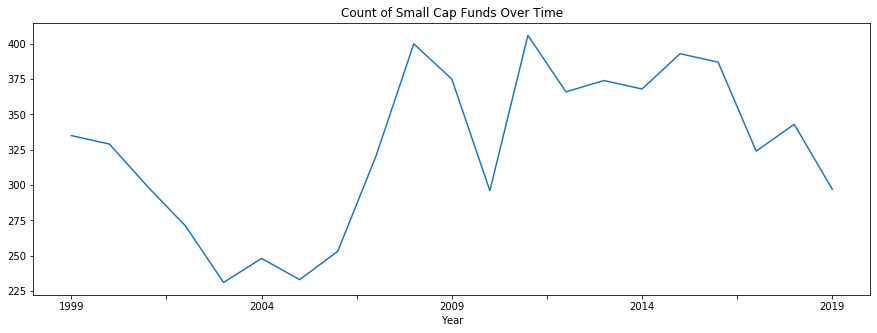

In [11]:
# Take a look at the counts of small cap funds over time (Annually)
count = df_merged.groupby(['Year'])[['crsp_fundno']].count().reset_index()
count['Year'] = count['Year'].astype(str)
count.plot(x='Year', 
           y=['crsp_fundno'],
           title='Count of Small Cap Funds Over Time',
           figsize=(15, 5),
           legend=None)

Text(0, 0.5, 'Return')

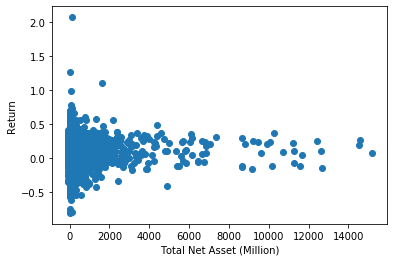

In [12]:
# Let's take a look at the relationship between Total Net Asset and Return
import matplotlib.pyplot as plt

plt.scatter(df_merged['tna_latest'],df_merged['mret'])
plt.xlabel('Total Net Asset (Million)')
plt.ylabel('Return')

In [13]:
# Run a regression 
from sklearn import linear_model
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats

df_merged2 = df_merged[['tna_latest', 'mret']].dropna()
y, X = dmatrices('mret ~ tna_latest', data=df_merged2, return_type='dataframe')

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
# Regression didn't give us meaningful result. 

                            OLS Regression Results                            
Dep. Variable:                   mret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.031
Date:                Mon, 19 Oct 2020   Prob (F-statistic):            0.00266
Time:                        22:14:14   Log-Likelihood:                 1494.2
No. Observations:                6758   AIC:                            -2984.
Df Residuals:                    6756   BIC:                            -2971.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0877      0.002     35.760      0.0

In [14]:
mask_1000 = df_merged['tna_latest'] < 1000
d1 = df_merged[mask_1000]['mret'].mean()

In [15]:
mask_1000_ = df_merged['tna_latest'] >= 1000
mask_4000 = df_merged['tna_latest'] < 4000
mask_1000_4000 = (mask_1000_ & mask_4000)
d2 = df_merged[mask_1000_4000]['mret'].mean()

In [16]:
mask_4000_ = df_merged['tna_latest'] >= 4000
mask_5000 = df_merged['tna_latest'] < 5000
mask_4000_5000 = (mask_4000_ & mask_5000)
d3 = df_merged[mask_4000_5000]['mret'].mean()

In [17]:
mask_5000_ = df_merged['tna_latest'] >= 5000
d4 = df_merged[mask_5000_]['mret'].mean()

In [18]:
# 12-Month Average Returns by Fund Size
print('12-Month Average Returns of Small Cap Funds with Fund Size less than 1-Billion:', "{:.2%}".format(df_merged[mask_1000]['mret'].mean()))
print('12-Month Average Returns of Small Cap Funds with Fund Size between 1-Billion and 4-Billion:', "{:.2%}".format(df_merged[mask_1000_4000]['mret'].mean()))
print('12-Month Average Returns of Small Cap Funds with Fund Size between 4-Billion and 5-Billion:', "{:.2%}".format(df_merged[mask_4000_5000]['mret'].mean()))
print('12-Month Average Returns of Small Cap Funds with Fund Size less than 5-Billion:', "{:.2%}".format(df_merged[mask_5000_]['mret'].mean()))

12-Month Average Returns of Small Cap Funds with Fund Size less than 1-Billion: 8.77%
12-Month Average Returns of Small Cap Funds with Fund Size between 1-Billion and 4-Billion: 12.96%
12-Month Average Returns of Small Cap Funds with Fund Size between 4-Billion and 5-Billion: 16.66%
12-Month Average Returns of Small Cap Funds with Fund Size less than 5-Billionn: 10.60%


In [19]:
d = {'Fund Size (Billion)': ['< 1', '1 - 4', '4 - 5 ', '> 5'], 'Average 12M Return': [d1, d2, d3, d4]}
df = pd.DataFrame(data=d)
df

,Fund Size (Billion),Average 12M Return
0,< 1,0.087710
1,1 - 4,0.129617
2,4 - 5,0.166641
3,> 5,0.106006


Text(0.5, 1.0, '12-Month Average Returns by Fund Size')

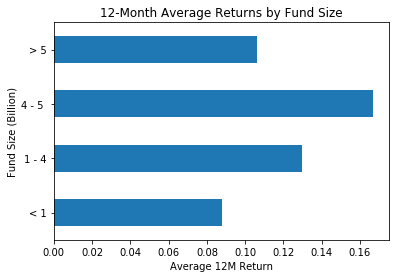

In [20]:
df.plot(kind='barh', x='Fund Size (Billion)', legend=None)
plt.xlabel('Average 12M Return')
plt.title('12-Month Average Returns by Fund Size')

In [21]:
#read fund summary data downloaded from WRDS
fund = pd.read_csv('fund summary v3.csv')

#selecting small cap value funds according to lipper classification
small_value_fund = fund[fund['lipper_class']=='SCVE']
sm_v_list = small_value_fund['crsp_fundno'].unique()

#read fund monthly return data downloaded from WRDS
mon_return = pd.read_csv('Monthly return.csv')

#selecting only returns for small cap value funds
sm_value_return = mon_return.loc[mon_return['crsp_fundno'].isin(sm_v_list)].dropna(subset= ['caldt','crsp_fundno','mtna', 'mret'])

In [22]:
#clean the data
def int_float(s):
    if isinstance(s, (float, int)):
        return float(s)
    else:
        try:
            return float(str(s).strip().strip('0').rstrip('.'))
        except:
            return 'error'

sm_value_return['mtna_clean'] = sm_value_return['mtna'].apply(int_float)
sm_value_return['mret_clean'] = sm_value_return['mret'].apply(int_float)
sm_value_return['mnav_clean'] = sm_value_return['mnav'].apply(int_float)

sm_value_return_clean = sm_value_return[(sm_value_return['mtna_clean'] != 'error') \
                                        & (sm_value_return['mret_clean'] != 'error') \
                                       & (sm_value_return['mnav_clean'] != 'error')]

sm_value_return_clean['datetime']= pd.to_datetime(sm_value_return_clean['caldt'])
sm_value_return_clean.set_index('datetime', inplace=True)

sm_value_return_clean['mtna_clean'] = pd.to_numeric(sm_value_return_clean['mtna_clean'])
sm_value_return_clean['mret_clean'] = pd.to_numeric(sm_value_return_clean['mret_clean'])
sm_value_return_clean['mnav_clean'] = pd.to_numeric(sm_value_return_clean['mnav_clean'])

sm_value_return_clean=sm_value_return_clean[sm_value_return_clean['crsp_fundno'] != 22169]
sm_value_return_clean=sm_value_return_clean[sm_value_return_clean['mtna_clean'] > 0]

In [23]:
sm_value_return_clean

,cusip8,caldt,crsp_fundno,mtna,mret,mnav,mtna_clean,mret_clean,mnav_clean
datetime,,,,,,,,,
2000-08-31,17296150,2000/08/31,292,5.800,0.042936,7.5300000,5.8,0.042936,7.53
2000-07-31,17296150,2000/07/31,292,7.200,0.004172,7.2200000,7.2,0.004172,7.22
2000-06-30,17296150,2000/06/30,292,8.800,0.004190,7.1900000,8.8,0.004190,7.19
1999-11-30,NaN,1999/11/30,292,16.400,0.014599,6.9500000,16.4,0.014599,6.95
1999-10-29,NaN,1999/10/29,292,18.000,-0.036568,6.8500000,18.0,-0.036568,6.85
...,...,...,...,...,...,...,...,...,...
2020-05-29,02507282,2020/05/29,96402,44.3,0.049333,7.87,44.3,0.049333,7.87
2020-04-30,02507282,2020/04/30,96402,34,0.225490,7.5,34.0,0.225490,7.50
2020-03-31,02507282,2020/03/31,96402,10.6,-0.281690,6.12,10.6,-0.281690,6.12


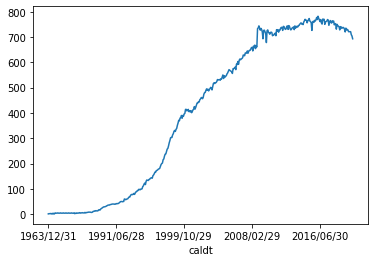

In [24]:
# ignore data prior to 2000 since the dataset are too small
sm_value_return_clean.groupby('caldt')['mtna'].count().plot()
start_date = pd.to_datetime('2000-1-1')
sm_value_return_clean=sm_value_return_clean.loc[sm_value_return_clean.index>=start_date]

In [25]:
#at each month, categorize the funds into small, medium and large size based on their reported TNA
sm_value_return_clean['rank']=sm_value_return_clean.groupby('caldt')['mtna_clean'].rank('first')
sm_value_return_clean['size'] = sm_value_return_clean.groupby('caldt')['rank'].\
                                 transform(lambda x: pd.cut(x, bins = 3, labels = False))
sm_value_return_clean.groupby(['caldt','size'])['mnav_clean'].count()

caldt       size
2000/01/31  0.0     138
            1.0     138
            2.0     138
2000/02/29  0.0     136
            1.0     136
                   ... 
2020/05/29  1.0     234
            2.0     235
2020/06/30  0.0     231
            1.0     231
            2.0     231
Name: mnav_clean, Length: 738, dtype: int64

In [26]:
#calculate the weight of each fund its repsective portfolio each month
sm_value_return_clean['weight'] = sm_value_return_clean['mtna_clean'] / sm_value_return_clean.groupby(['caldt','size'])['mtna_clean'].transform('sum')
sm_value_return_clean['weighted return'] = sm_value_return_clean['weight'] * sm_value_return_clean['mret_clean']
sm_value_return_clean['weighted mtna'] = sm_value_return_clean['weight'] * sm_value_return_clean['mtna_clean']

In [27]:
#calculate the portfolio return based on the weighted return of the underlying funds
pivoted = pd.pivot_table(sm_value_return_clean,
                        index=sm_value_return_clean.index, 
                        columns = 'size',
                        values = 'weighted return',
                        aggfunc=sum)
pivoted.columns = ['small','medium','large']
pivoted

,small,medium,large
datetime,,,
2000-01-31,-0.027980,-0.028686,-0.031040
2000-02-29,0.058049,0.053451,0.054270
2000-03-31,0.039504,0.043488,0.032385
2000-04-28,-0.016098,-0.013634,-0.013609
2000-05-31,-0.021046,-0.019754,-0.013200
...,...,...,...
2020-02-28,-0.101729,-0.100921,-0.098473
2020-03-31,-0.254314,-0.242007,-0.219188
2020-04-30,0.141740,0.139236,0.134306


In [28]:
#downloaded russell_2000 data from yahoo finance
russell_2000 = pd.read_csv('RUT.csv')
russell_2000['price-1'] = russell_2000['Adj Close'].shift(1)
russell_2000['return'] = russell_2000['Adj Close']/russell_2000['price-1']-1
russell_2000 = russell_2000.iloc[1:]
russell_2000.index = pivoted.index

In [29]:
benchmark_adj = pivoted.join(russell_2000['return'])
benchmark_adj

,small,medium,large,return
datetime,,,,
2000-01-31,-0.027980,-0.028686,-0.031040,-0.016880
2000-02-29,0.058049,0.053451,0.054270,0.164198
2000-03-31,0.039504,0.043488,0.032385,-0.066850
2000-04-28,-0.016098,-0.013634,-0.013609,-0.060918
2000-05-31,-0.021046,-0.019754,-0.013200,-0.059398
...,...,...,...,...
2020-02-28,-0.101729,-0.100921,-0.098473,-0.085269
2020-03-31,-0.254314,-0.242007,-0.219188,-0.218995
2020-04-30,0.141740,0.139236,0.134306,0.136640


Text(0, 0.5, 'cumulative return')

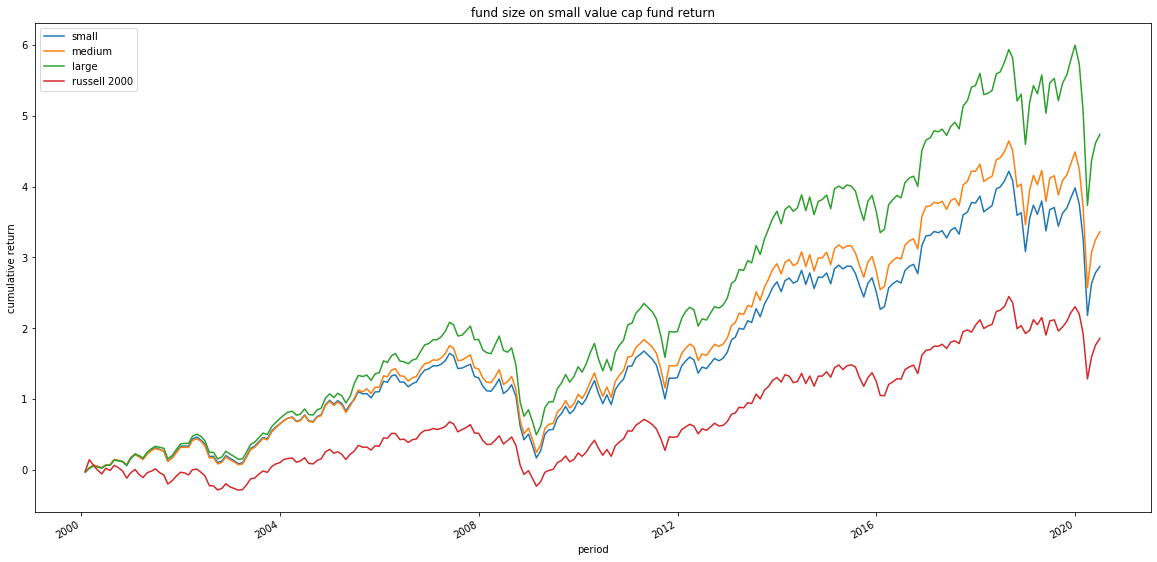

In [30]:
# calculated the cumulative return and plot the graphs
cumulative = ((benchmark_adj + 1).cumprod() - 1)
cumulative.columns = ['small', 'medium', 'large','russell 2000']
cumulative.plot(figsize=(20,10))
plt.title("fund size on small value cap fund return")
plt.xlabel('period')
plt.ylabel('cumulative return')